# Maximum temperature, marginal distribution
Examples of using the trained convCNP model to predict maximum temperatures. This model trained on 3010 sites from the ECA&D dataset (Klein Tank et al., 2002). Here, data is provided from 01/10/2008-31/12/2008 to query the trained model at the 86 held out VALUE stations. 

In [1]:
import pickle as pkl
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go

from numpy.random import gamma, binomial
import numpy as np
import scipy
import pandas as pd 
import xarray as xr 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from convCNP.models.elev_models import TmaxBiasConvCNPElev
from convCNP.models.cnn import CNN, ResConvBlock, UNet
from convCNP.validation.utils import get_dists, generate_context_mask, get_output, load_model

## Load the data

In [3]:
device = torch.device('cpu')

In [4]:
# ERAI context data (scaled)
context_grids = torch.from_numpy(np.load("examples/data/erai_2008.npy")).float()

# Context gridpoint coordinates (scaled)
x_context = torch.load("examples/data/x_context", map_location=device)

# Target coordinates (scaled)
x_target = torch.load("examples/data/x_target", map_location=device)

# Elevation data at the context points
elev = torch.from_numpy(np.load("examples/data/tmax_elev_value.npy")).float()

# And observations to compare to 
obs = torch.from_numpy(np.load("examples/data/obs_2008_target.npy")).float()

# List of stations
stations = pd.read_csv("examples/data/stations.txt")

Locations of the 86 held out VALUE stations are shown below

In [5]:
import plotly.express as px

fig = go.Figure(data=go.Scattergeo(
        lon = stations[' longitude'],
        lat = stations[' latitude'],
        text = stations[' name'],
        mode = 'markers',
        marker_color = stations[' altitude'],
        ))

fig.update_layout(
        title = 'VALUE stations<br>(Hover for names)',
        geo_scope='europe',
    )
fig.show()

## Load model

In [6]:
from numpy.random import normal

def get_value_tmax(p):
    """
    For the predictions make actual predicted values as the 
    mean
    """
    return p[:, :, 0]

def get_value_tmax_stochastic(p):
    """
    For the predictions make actual predicted values as the 
    mean
    """
    return normal(p[...,0], p[...,1])

In [21]:
def plot_at_station(name, stations, predictions, obs):
    """
    Plot predictions vs. observations at a given station
    """
    # Get station index
    station_ind = stations[stations[" name"]==" "+name].index.values[0]
    
    plt.style.use('seaborn-white')
    y_mu = predictions[:,station_ind, 0]
    y_sigma = predictions[:,station_ind, 1]
    obs = obs[:, station_ind]
    x = pd.date_range(start="2008-10-01",end="2008-12-30").values
    plt.figure(figsize=(8, 3), dpi= 300, facecolor='w', edgecolor='k')
    plt.plot(x,obs, label="observed", color="r")
    plt.plot(x,y_mu, label="predicted mean", color="b")
    plt.title("Maximum temperature ({})".format(name))
    plt.ylabel("(C)")
    
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter("%d/%m/%y")
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
    
    plt.fill_between(x,y_mu-2*y_sigma, y_mu+2*y_sigma, label = "2*predicted sigma", color="b", alpha=0.5)
    plt.legend(loc="upper right")
    plt.show()

## Make predictions

In [8]:
dists = get_dists(x_target, x_context[:, :, 0], x_context[:, :, 1])
path = 'examples/trained_models/tmax_marginal_ecad_train'
model = load_model(path, 25, x_context, x_target, device)
predictions = get_output(model, context_grids, dists, elev.float())

In [13]:
# Get values taking mean of predicted distribution
pred = get_value_tmax(predictions)

# Get values sampling from predicted distribution
pred = get_value_tmax_stochastic(predictions)

## Plot predictions at a given station

Comparison between observations and model predictions can be plotted using the plot_at_station function. As an example, plot the maximum temperature at Graz, Austria

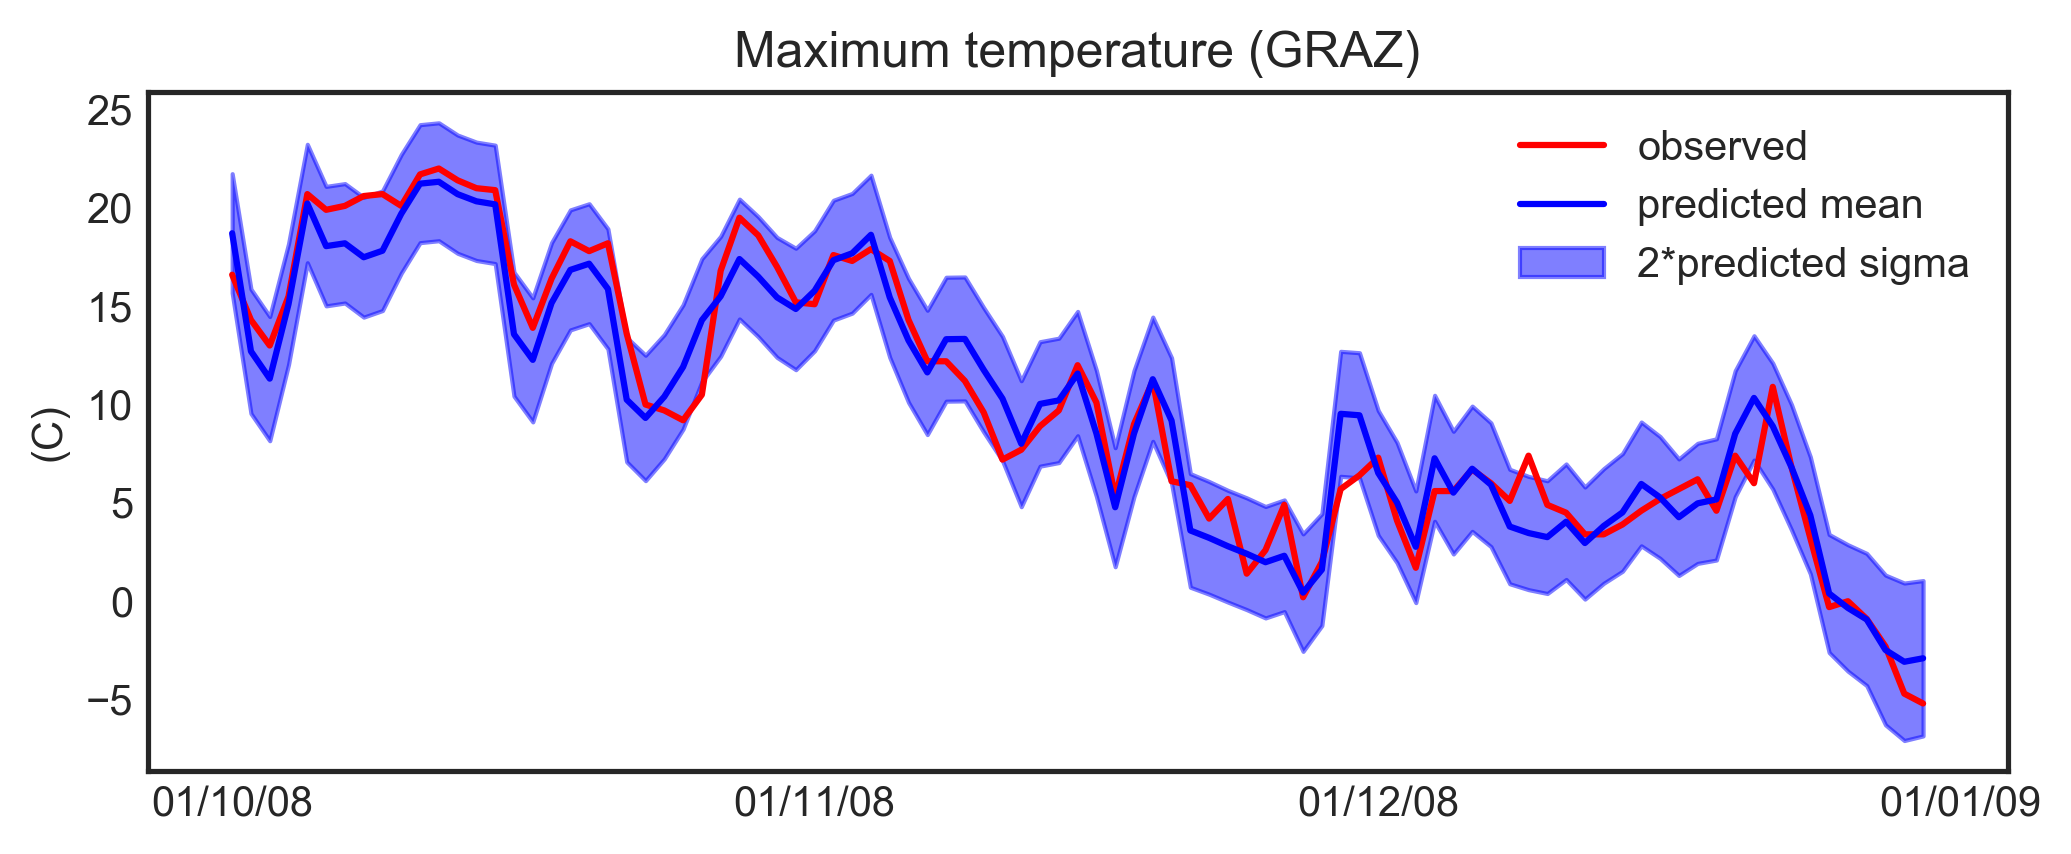

In [22]:
plot_at_station("GRAZ", stations, predictions, obs)

Oxford, UK

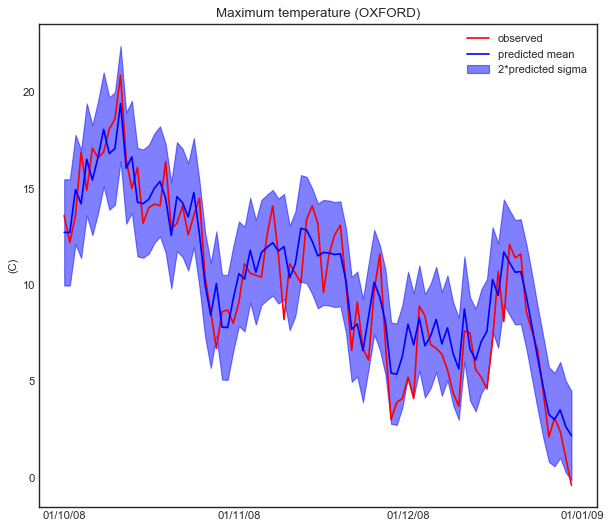

In [15]:
plot_at_station("OXFORD", stations, predictions, obs)

and Utsira, Norway

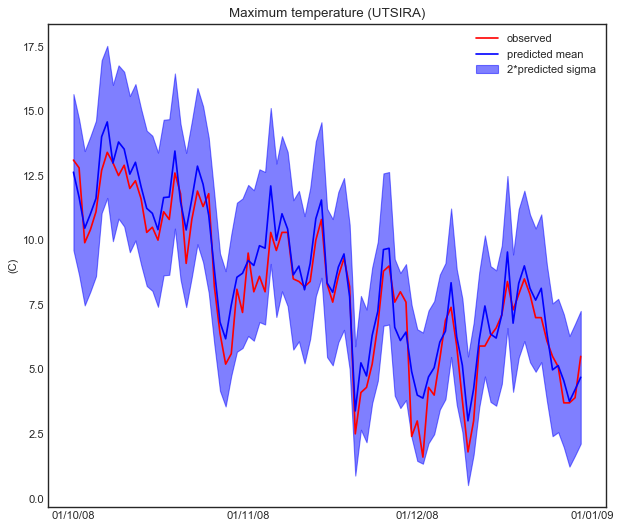

In [12]:
plot_at_station("UTSIRA", stations, predictions, obs)